In [40]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import sep
from astropy import wcs
from photutils.psf import EPSFBuilder
from photutils.psf import EPSFModel
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from astropy.modeling.fitting import LevMarLSQFitter, FittingWithOutlierRemoval
from astropy.table import Table
from astropy.nddata import NDData
from photutils.psf import extract_stars
from astropy.visualization import simple_norm
from photutils.psf import BasicPSFPhotometry
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from astropy.modeling.fitting import LevMarLSQFitter

def trim_image(image, wd):
    nx, ny = np.shape(image)
    
    return image[wd:nx-wd, wd:ny-wd]
    
def draw_cicle(shape,diamiter):
    '''
    Input:
    shape    : tuple (height, width)
    diameter : scalar
    
    Output:
    np.array of shape  that says True within a circle with diamiter =  around center 
    '''
    assert len(shape) == 2
    TF = np.zeros(shape,dtype=np.bool)
    center = np.array(TF.shape)/2.0

    for iy in range(shape[0]):
        for ix in range(shape[1]):
            TF[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < diamiter **2
    return(TF)

def trim_image(image, wd):
    nx, ny = np.shape(image)
    
    return image[wd:nx-wd, wd:ny-wd]

def load_trim_image(file, wd =100):
    hdul = fits.open(file )
    image = hdul[0].data
    wcs_now = wcs.WCS(hdul[0].header)
    trim_data = trim_image(image, wd)
    return trim_data

def make_image_names(name):
    j_image = "/Volumes/G-DRIVE/sirius/jWCGCFits/jWGC%s.fits" % name
    h_image = "/Volumes/G-DRIVE/sirius/hWCGCFits/hWGC%s.fits.gz" % name
    k_image = "/Volumes/G-DRIVE/sirius/kWCGCFits/kWCGC%s.fits.gz" % name
    images = [j_image, h_image, k_image]
    images = [j_image, k_image]
    return images
    

def return_one_loop_test(image, niter = 5, thr = 90):
    
    trim_data_for_sep = image.byteswap().newbyteorder()
    image_now = trim_data_for_sep
    bkg_now = None
    image_arr = []
    bkg_arr = []
    source_arr = []
    psf_arr = []
    epsf_now= None

    if bkg_now is None:
        image_arr.append(image_now)
        bkg_now= sep.Background(image_now, bw = 10, bh = 10, fw = 3, fh = 3)
        bkg_arr.append(bkg_now)
    data_bkg_sub = image_now- bkg_now
    objects = sep.extract(data_bkg_sub, 3.5, err=bkg_now.globalrms)

    flux_lim= np.percentile(objects["flux"], thr)
    objects_lim = objects[objects["flux"]>flux_lim]

    size = 35
    hsize = (size - 1) / 2
    x = objects_lim["x"]
    y = objects_lim["y"]
    mask = ((x > hsize) & (x < (data_bkg_sub.shape[1] -1 - hsize)) & (y > hsize) & (y < (data_bkg_sub.shape[0] -1 - hsize))) 
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]  
    stars_tbl['y'] = y[mask]  
    nddata = NDData(data=data_bkg_sub)
    stars = extract_stars(nddata, stars_tbl, size=25)  
    nrows = 5
    ncols = 5

    if epsf_now is None:
        epsf_builder = EPSFBuilder(oversampling=1, maxiters=4, progress_bar=True)  
        epsf_now, fitted_stars = epsf_builder(stars)  
    
    

    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()
    daogroup = DAOGroup(crit_separation=8)


    photometry = BasicPSFPhotometry(
    group_maker=daogroup, bkg_estimator=bkg_estimator, psf_model=epsf_now,
    fitter=LevMarLSQFitter(), fitshape=(5,5), aperture_radius = 15)

    result_tab = nddata
    pos = Table(names=['x_0', 'y_0'], data=[x, y])
    result_tab = photometry(image=data_bkg_sub, init_guesses=pos)
    residual_image = photometry.get_residual_image()
    source_now = data_bkg_sub - residual_image
    image_now = residual_image + bkg_now
    bkg_now= sep.Background(image_now, bw = 40, bh = 40, fw = 3, fh = 3)
    image_arr.append(image_now)
    source_arr.append(source_now)
    bkg_arr.append(bkg_now)
    psf_arr.append(epsf_now)
    return  image_arr, bkg_arr, source_arr, psf_arr

def coordinate_make(x_len, y_len, dx, dy):
    x = np.arange(0,x_len * dx, dx)
    y = np.arange(0,y_len * dy, dy)
    x_shift = x - np.mean(x)
    y_shift = y - np.mean(y)
    yy, xx= np.meshgrid(x_shift, y_shift, indexing='ij')

    du = 1/(dx * x_len)
    dv = 1/(dy * y_len)
    u = np.arange(0,x_len * du, du)
    v = np.arange(0,y_len * dv, dv)
    u_shift = u - np.mean(u)
    v_shift = v - np.mean(v)

    vv, uu= np.meshgrid(u_shift, v_shift, indexing='ij')
    return xx, yy, uu, vv

def make_rad_prof(image, x_cen, y_cen):
    
    x_len, y_len = np.shape(image)
    x = np.arange(0,x_len)
    y = np.arange(0,y_len)
    yy, xx= np.meshgrid(x, y, indexing='ij')
    rr = np.sqrt( (yy-y_cen)**2 + (xx-x_cen)**2 )
    rr_1d = np.ravel(rr)
    image_1d = np.ravel(image)

    return rr_1d, image_1d

def estimate_bkg(image, r_out=13):

    x_len, y_len = np.shape(image)
    arg_now = np.unravel_index(np.argmax(image), image.shape)
    x_cen = arg_now[0]
    y_cen = arg_now[1]
    x = np.arange(0,x_len)
    y = np.arange(0,y_len)
    yy, xx= np.meshgrid(x, y, indexing='ij')
    rr = np.sqrt( (yy-y_cen)**2 + (xx-x_cen)**2 )
    return np.median(image[rr>r_out])

def modify_psf(psf, r_out=13):
    bkg_now = estimate_bkg(psf.data, r_out)
    psf_new = EPSFModel(psf.data - bkg_now)
    return psf_new

def masking_image(image, x_arr, y_arr, flux_arr, flux_min, wd):
    mask = np.ones(np.shape(image))==0
    bkg_now = np.median(image)
    for i in range(len(x_arr)):     
        if flux_arr[i] > flux_min:
            mask[int(x_arr[i])-wd:int(x_arr[i])+wd, int(y_arr[i])-wd:int(y_arr[i])+wd] = True
    bkg_now = np.median(image[mask==False])
    image[mask] = bkg_now
    return image
                    


def return_one_loop(image, niter = 5, thr = 90, with_mask = True, subtract_psf_outer = True):
    
    trim_data_for_sep = image.byteswap().newbyteorder()
    image_now = trim_data_for_sep
    bkg_now = None
    image_arr = []
    bkg_arr = []
    source_arr = []
    psf_arr = []
    epsf_now= None
    stars_first = None
                     
    bkg_func = lambda x: sep.Background(x, bw = 40, bh = 40, fw = 5, fh = 5)
    
    for i in range(niter):
        
        ## Initial estimation of BKG
        if bkg_now is None:
            image_arr.append(image_now)
            bkg_now= bkg_func(image_now)
            bkg_arr.append(bkg_now)
            plt.title("original image")
            plt.imshow(image_now, vmin = 100, vmax = 150)
            plt.colorbar()
            plt.show()
        

        ## Point source detection
        data_bkg_sub = image_now- bkg_now
        objects = sep.extract(data_bkg_sub, 3.5, err=bkg_now.globalrms)
        flux_lim= np.percentile(objects["flux"], thr)
        objects_lim = objects[objects["flux"]>flux_lim]

        ## Making star lists 
        size = 50
        hsize = (size - 1) / 2
        x = objects_lim["x"]
        y = objects_lim["y"]
        flux = objects_lim["flux"]

        
        mask = ((x > hsize) & (x < (data_bkg_sub.shape[1] -1 - hsize)) & (y > hsize) & (y < (data_bkg_sub.shape[0] -1 - hsize))) 
        if len(x[mask]) == 0:
            return   image_arr, bkg_arr, source_arr, psf_arr
        stars_tbl = Table()
        stars_tbl['x'] = x[mask]  
        stars_tbl['y'] = y[mask]  
        nddata = NDData(data=data_bkg_sub)
        stars = extract_stars(nddata, stars_tbl, size=size)  
        if stars_first is None:
            stars_first = stars

        ## Construct PSF model at initial loop
        if epsf_now is None:
            epsf_builder = EPSFBuilder(oversampling=1, maxiters=1, progress_bar=True)  
            epsf_now, fitted_stars = epsf_builder(stars) 
            if subtract_psf_outer:
                epsf_now = modify_psf(epsf_now)
    
    
        bkg_estimator =bkg_func# MedianBackground()
        daogroup = DAOGroup(crit_separation=8)
        photometry = BasicPSFPhotometry(
        group_maker=daogroup, bkg_estimator=bkg_estimator, psf_model=epsf_now,
        fitter=LevMarLSQFitter(), fitshape=(35,35), aperture_radius = 35)

        result_tab = nddata
        pos = Table(names=['x_0', 'y_0'], data=[x, y])
        result_tab = photometry(image=data_bkg_sub, init_guesses=pos)
        residual_image = photometry.get_residual_image()
        source_now = data_bkg_sub - residual_image
        
        
        image_now = residual_image + bkg_now
        if with_mask:
            image_now =  masking_image(image_now, y, x, flux, 5000, 25)
        bkg_now= bkg_func(image_now)#sep.Background(image_now, bw = 50, bh = 50, fw = 7, fh = 7)
        image_arr.append(image_now)
        source_arr.append(source_now)
        bkg_arr.append(bkg_now)
        psf_arr.append(epsf_now)
        plt.title("image after source subtractoin ite%d" % i)
        plt.imshow(image_now, vmin = 100, vmax = 150)
        plt.colorbar()
        plt.show()
    return  image_arr, bkg_arr, source_arr, psf_arr, stars_first

def show_stars(stars, nrows = 5, ncols = 5):
    
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                           squeeze=True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(stars[i], 'log', percent=99.)
        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

def show_bkg(bkgs, nrows = 5, ncols = 5):
    
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                           squeeze=True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(bkgs[i], 'log', percent=99.)
        ax[i].imshow(bkgs[i], norm=norm,  cmap='viridis')
        ax[i].set_title("background ite%d" % i)
        
        
from scipy.optimize import curve_fit
from scipy import optimize

def moffat_func(I_0, theta, beta):
    return lambda x: I_0 * (1 + (x/theta)**2)**(-beta)

def moffat_func_const_bkg(I_0, theta, bkg):
    return lambda x: I_0 * (1 + (x/theta)**2)**(-2.3) + bkg

def moffat_func_bkg(I_0, theta, beta, bkg):
    return lambda x: I_0 * (1 + (x/theta)**2)**(-beta) + bkg


def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    Y,X = np.indices(data.shape)
    nx, ny = np.shape(X)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    
    ## x or y can be minus or large when total ~ 0
    if x<0:
        x = int(nx/2)
    if y<0:
        y = int(ny/2)
    if x>nx-1:
        x = nx-1
    if y>ny-1:
        y = ny-1
       
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 0, 0


def fitmoffat_radial(r_1d, I_1d, data, centers= None, const_beta = True):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    

    params = moments(data)
    bkg_now = np.median(data)
    I_0 = np.max(data)
    if const_beta:
        params = [I_0, params[3]*0.1, 1, bkg_now]
        errorfunction = lambda p: moffat_func_bkg(*p)(r_1d) - I_1d
        p, success = optimize.leastsq(errorfunction, params)
        model_function = moffat_func_bkg(*p)
        model_rr = model_function(r_1d)

        return p, success,  model_function, model_rr
    else:
        params = [I_0, params[3],  bkg_now]
        errorfunction = lambda p: moffat_func_const_bkg(*p)(r_1d) - I_1d
        p, success = optimize.leastsq(errorfunction, params)
        model_function = moffat_func_const_bkg(*p)
        model_rr = model_function(r_1d)

        return p, success,  model_function, model_rr  
    
#name = "1742-3020D"
name = "1745-2900G"
image_names = make_image_names(name)
## data load
trim_data = load_trim_image(image_names[0], wd = 200)


n_iter = 20 ## number of iteration between bkg <-> source extraction loop

 

In [26]:
## making subctraction residual

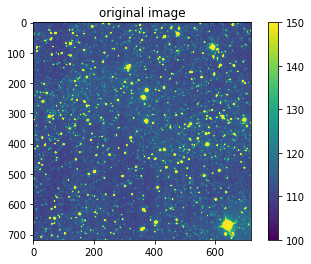

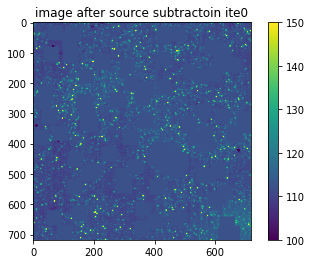

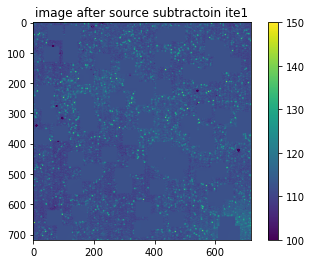

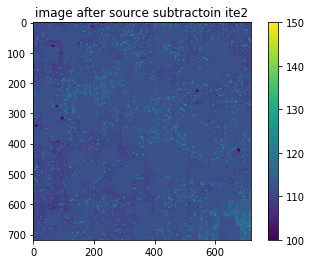

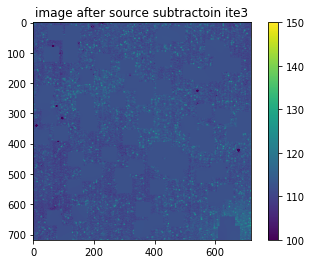

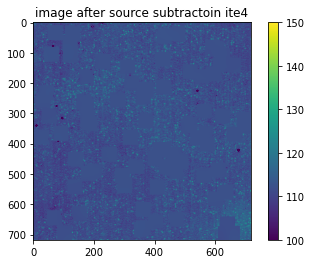

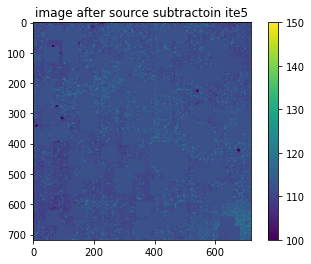

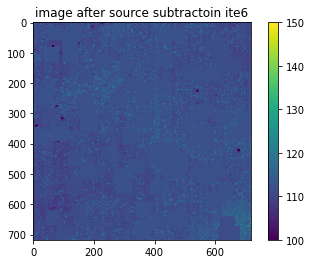

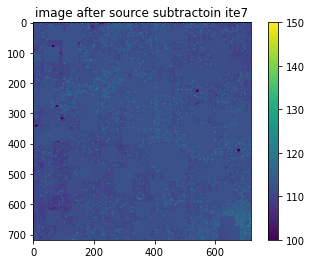

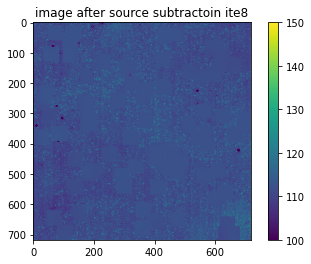

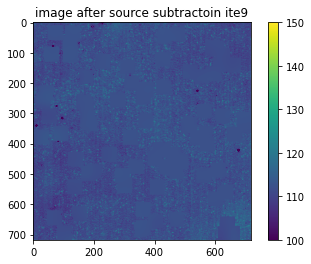

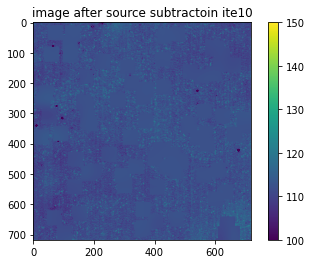

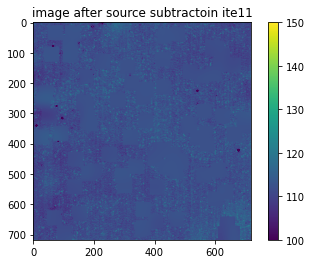

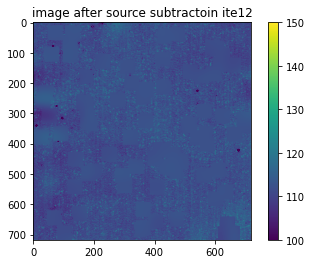

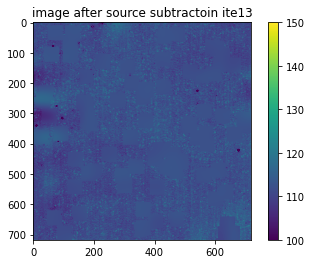

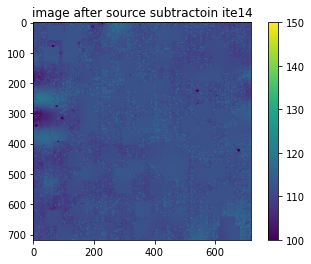

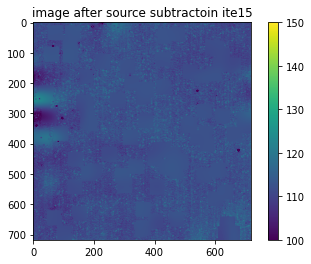

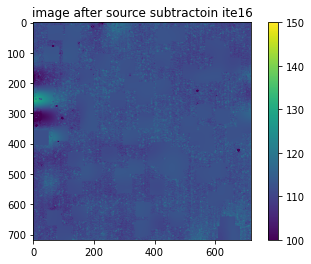

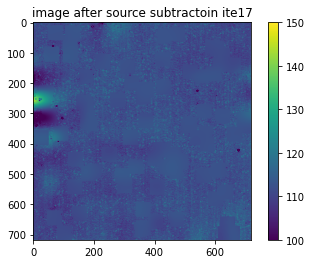

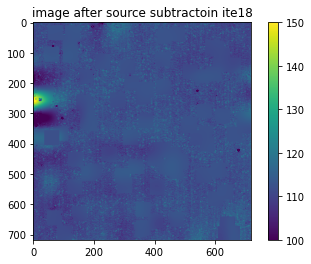

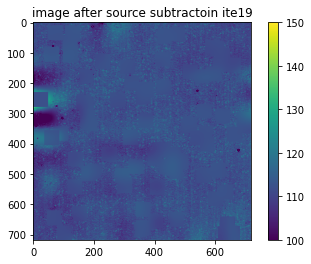

In [27]:
image_arr_mask, bkg_arr_mask, source_arr_mask, psf_arr_mask, stars_first = return_one_loop(trim_data, n_iter , 80, True, False)

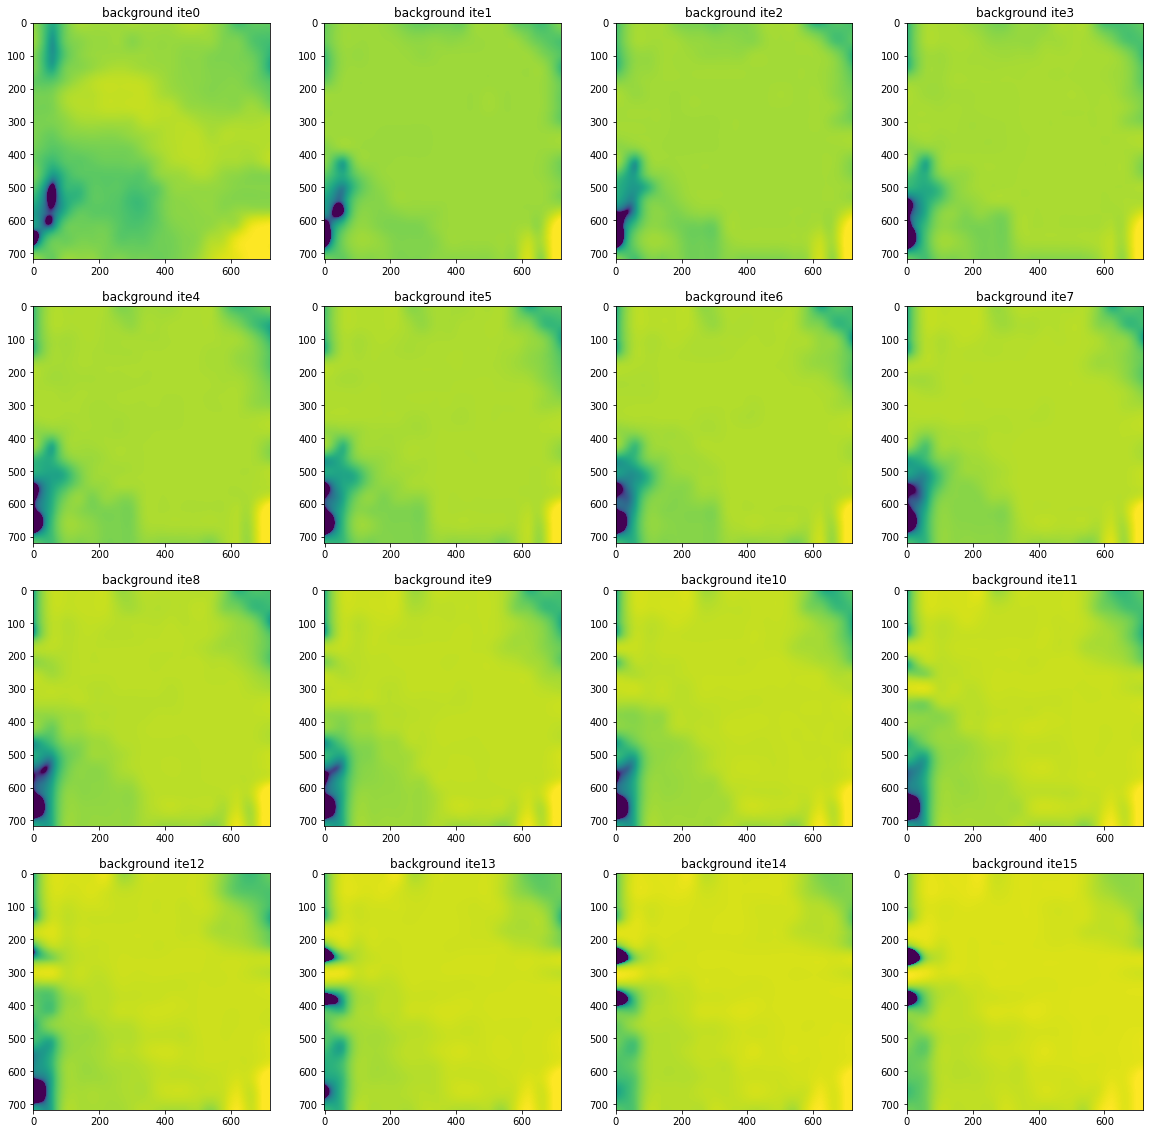

In [41]:
bkg_arr_mask

show_bkg(bkg_arr_mask, nrows = 4, ncols = 4)

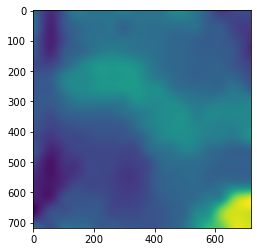

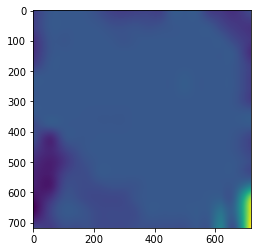

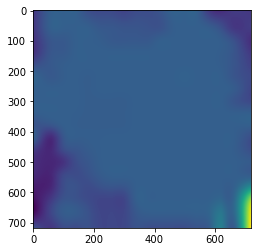

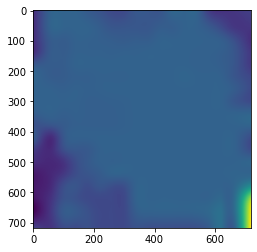

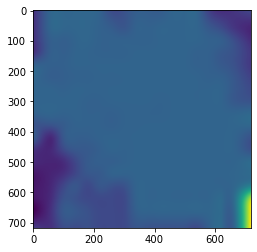

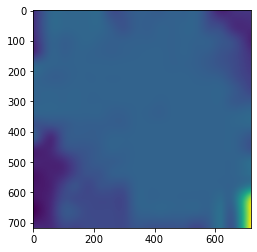

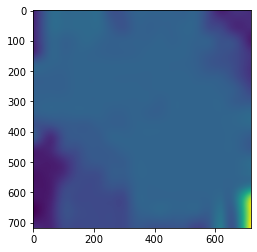

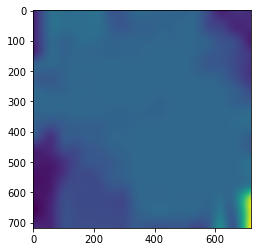

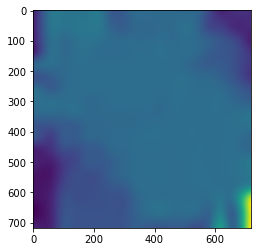

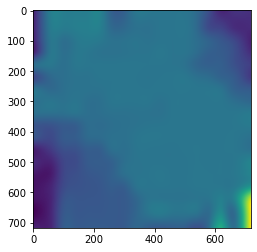

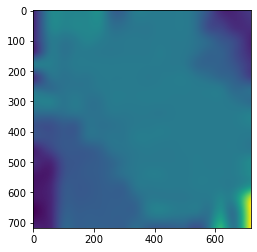

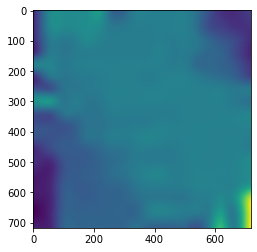

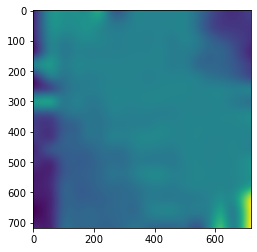

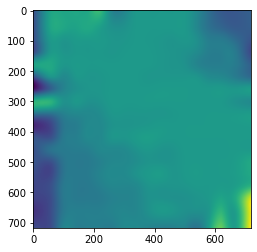

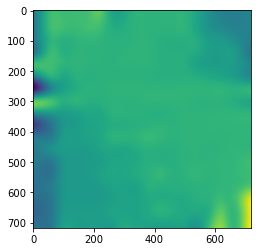

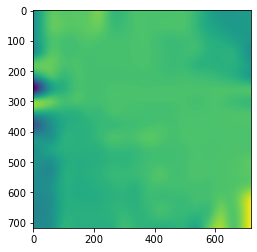

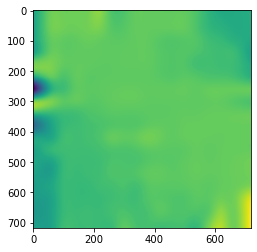

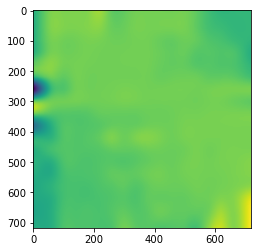

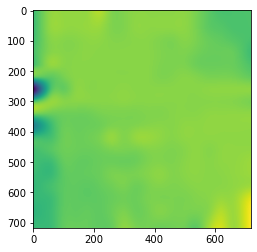

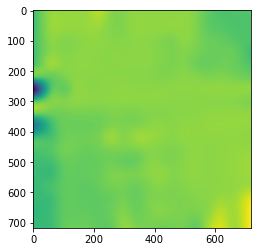

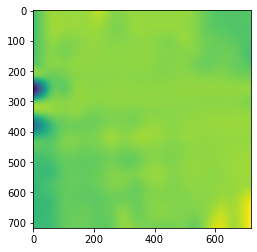

In [30]:
for i in range(len(bkg_arr_mask)):
    plt.imshow(bkg_arr_mask[i])
    plt.show()

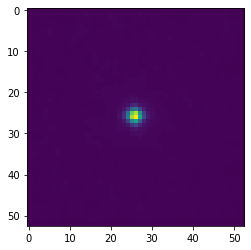

In [45]:
plt.imshow(psf_arr[0].data)

(-0.0001, 0.0005)

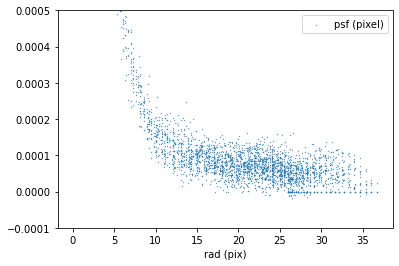

In [21]:

    
    
index = 0
data = psf_arr_mask[index].data
arg_now = np.unravel_index(np.argmax(data), data.shape)
rr_1d,image_1d = make_rad_prof(data ,arg_now [0], arg_now [1])

p, success,  model_function, model_rr = fitmoffat_radial(rr_1d,image_1d, data,  const_beta =True)
plt.scatter(rr_1d, image_1d, s =0.1, label="psf (pixel)")
#plt.scatter(rr_1d,model_rr , s =0.1, label="model")
#plt.yscale("log")
plt.xlabel("rad (pix)")
plt.legend()
plt.ylim(-0.0001, 0.0005)    

In [30]:
## Show deceted stars in the first iteration

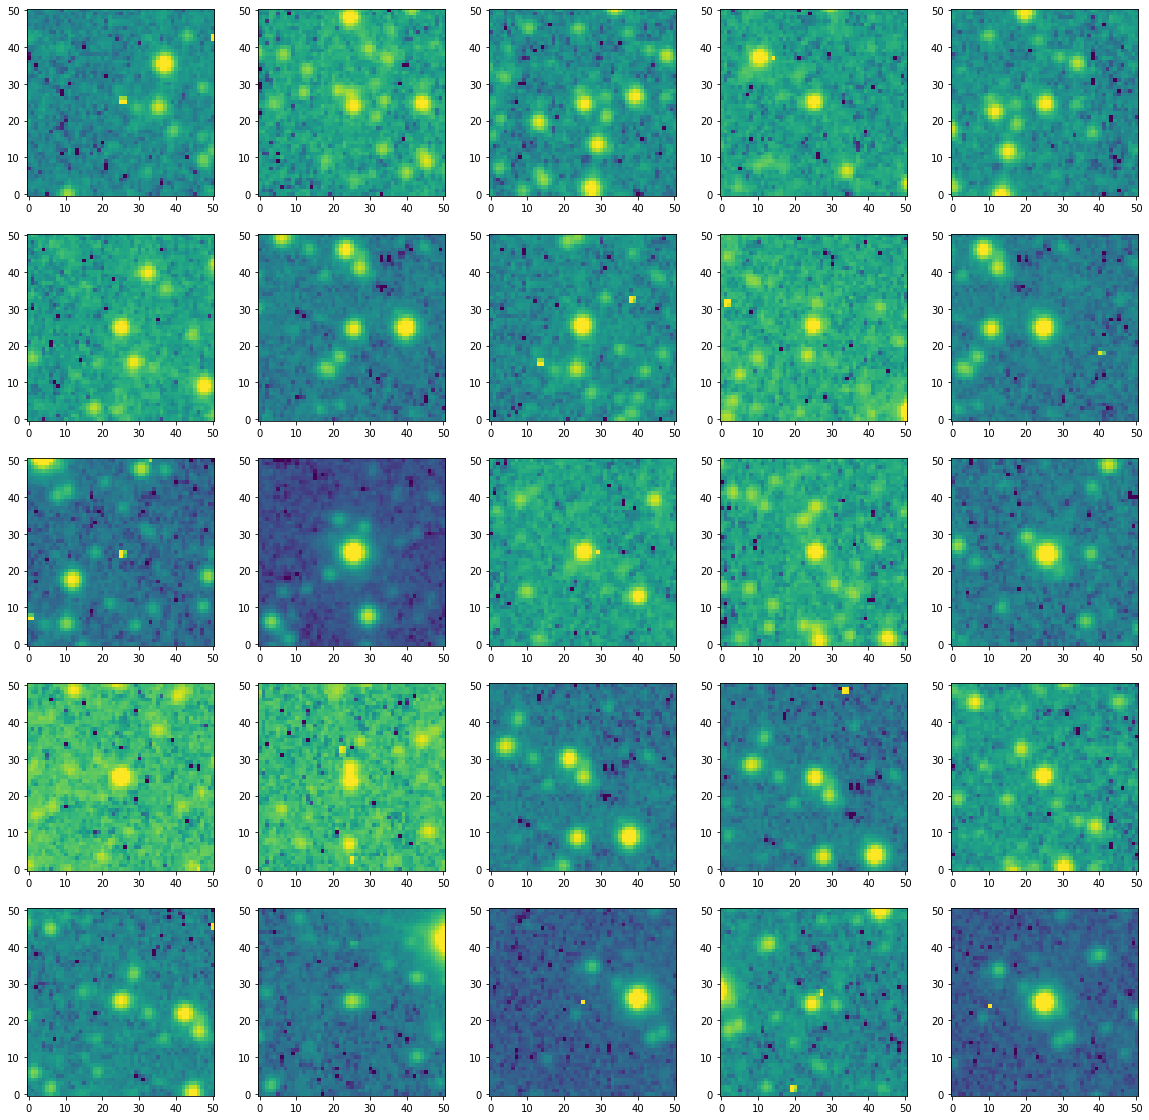

In [39]:
show_stars(stars_first)

In [ ]:
## Imaging analysis without masking

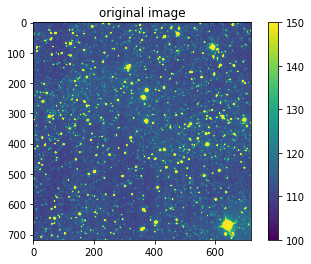

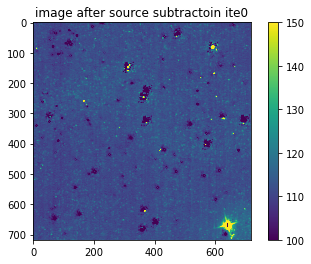

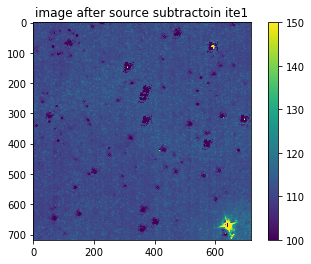

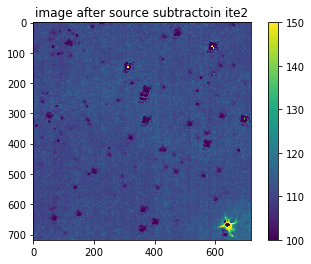

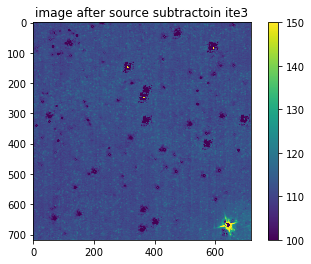

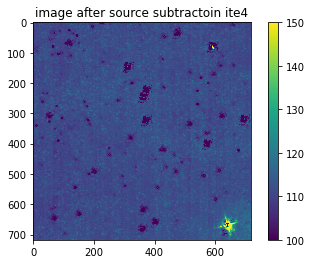

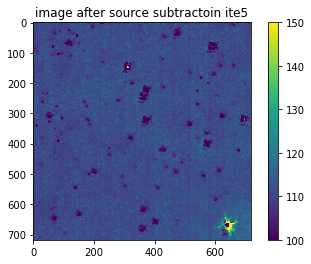

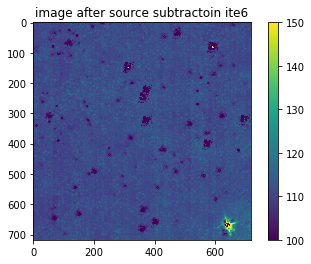

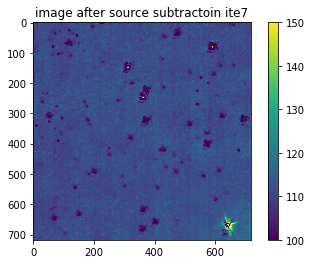

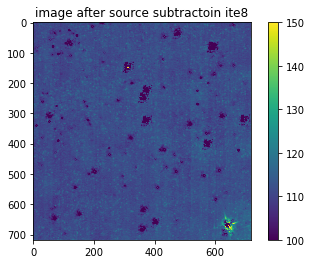

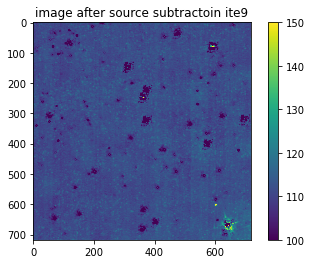

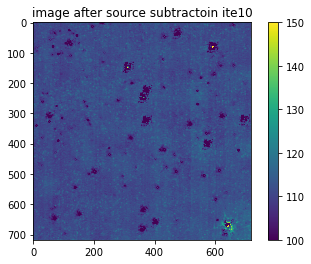

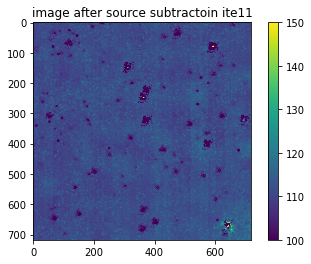

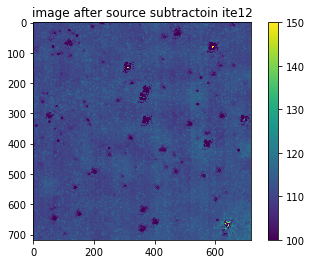

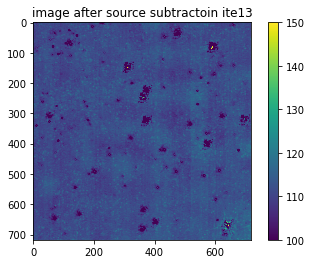

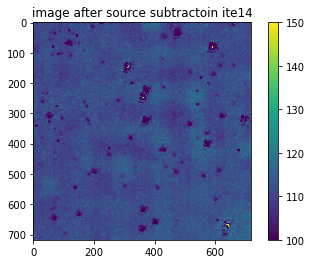

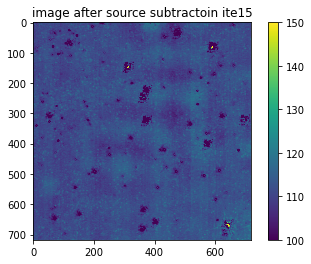

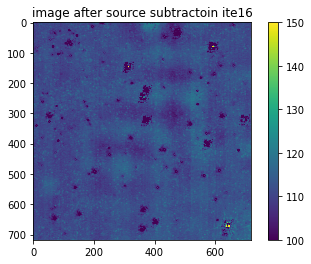

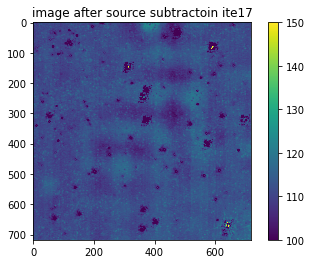

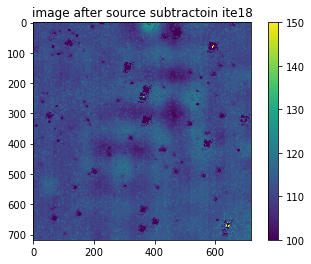

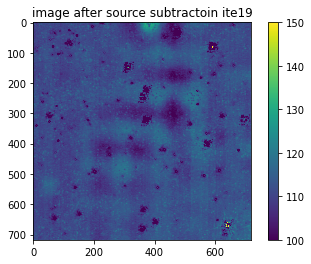

ValueError: too many values to unpack (expected 4)

In [14]:
image_arr_mask, bkg_arr_mask, source_arr_mask, psf_arr_mask = return_one_loop(trim_data, n_iter , 0, False, True)


In [ ]:
## changing bkg scales

In [ ]:

width_arr = [10, 15, 20, 30, 50]
for width_now in width_arr:
    bkg_func = lambda x: sep.Background(x, bw = width_now, bh = width_now, fw = 5, fh = 5)
    bkg_now= bkg_func(image_arr[0])
    plt.imshow(bkg_now)
    plt.show()
    
    

In [ ]:
## changing bkg scales

In [4]:
## psf fitting

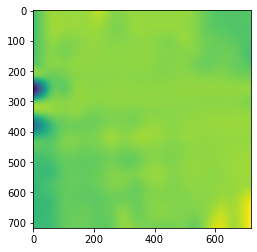

In [24]:
for i in range(len(bkg_arr_mask)):
    plt.imshow(bkg_arr_mask[i])